In [70]:
from mynn.activations.relu import relu
from mygrad.nnet.layers import max_pool
#from mygrad.nnet.losses import huber_loss as softmax_crossentropy
from mynn.losses.huber_loss import huber_loss as softmax_crossentropy
from mynn.initializers.glorot_uniform import glorot_uniform
from mynn.layers.dense import dense
from mynn.layers.conv import conv
from noggin import create_plot
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import misc
import mygrad as mg
import pickle
from mynn.layers.dropout import dropout 
import scipy
%matplotlib notebook
from PIL import Image

In [71]:
class ModelOG(): #Different size data: Dataset Samples
    def __init__ (self):
        init_kwargs = {'gain': np.sqrt(2)} #Might Change
        self.conv1 = conv(3, 35 , 40, 2,stride=(2,2), 
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.conv2 = conv(35, 15, 1, 4, stride = ( 2 , 2),
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.dense1 = dense(180, 90, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dense2 = dense(90, 45, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dense3 = dense(45, 15, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dropout = dropout(.5)
    def __call__(self, image):
        """Input
        ___________
        image (Channel, Length, Width)
        
        Output
        ___________
        size 15 list
        
        """
        #return self.dense2(relu(self.dense1(relu)))
        print(f"The image before any layers is {image.shape}")
        x = relu(self.dropout(self.conv1(image)))
        print(f"The input after the first conv is {x.shape}")
        x = max_pool(x, (2, 2), 2)
        print(f"The input after the first pool is {x.shape}")
        x = relu(self.dropout(self.conv2(x)))
        print(f"The input after the second conv is {x.shape}")
        x = max_pool(x, (2, 2), 2)
        print(f"The input after the second pool is {x.shape}")

        #x=mg.Tensor(np.ravel(x.data))
        x = x.reshape(x.shape[0], -1) 
        print(f"The input after flattening is {x.shape}")
        
        
        x = relu (self.dense1(x))
        print(f"The input after the first dense layer is {x.shape}")
        x = relu (self.dropout(self.dense2(x)))
        print(f"The input after the second dense is {x.shape}")
        x = relu (self.dropout(self.dense3(x)))
        print(f"The input after the third dense is {x.shape}")
        x=np.rint(x.data)
        #ret = []
        #for i in np.arange(x.shape[0]):
        #    ret.append(self.decoder(x[i]))
        return x
    
    @property
    def parameters(self):
        '''Returns the weights of the model'''
        return list(self.conv1.parameters)+list(self.conv2.parameters)+list(self.dense1.parameters)+list(self.dense2.parameters)+list(self.dense3.parameters)
        

In [72]:
class Model():
    def __init__ (self):
        init_kwargs = {'gain': np.sqrt(2)} #Might Change
        self.conv1 = conv(3, 35 , 18, 2,stride=(2,2), 
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.conv2 = conv(35, 15, 14, 28, stride = ( 2 , 2),
                          weight_initializer=glorot_uniform, 
                          weight_kwargs=init_kwargs)
        self.dense1 = dense(210, 90, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dense2 = dense(90, 45, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dense3 = dense(45, 15, 
                            weight_initializer=glorot_uniform, 
                            weight_kwargs=init_kwargs)
        self.dropout = dropout(.5)
    def __call__(self, image):
        """Input
        ___________
        image (Channel, Length, Width)
        
        Output
        ___________
        size 15 list
        
        """
        assert len(image.shape) ==3 or len(image.shape) ==4, f"The size of input is {image.shape} while we need "
        #return self.dense2(relu(self.dense1(relu)))
        #print(f"The [model] image before any layers is {image.shape}")
        x = mg.Tensor(relu(self.dropout(self.conv1(image))).data,dtype=int)
        #print(f"The input after the first conv is {x.shape}")
        x = mg.Tensor(max_pool(x, (2, 2), 2).data,dtype=int)
        #print(f"The input after the first pool is {x.shape}")
        x = mg.Tensor(relu(self.dropout(self.conv2(x))).data,dtype=int)
        #print(f"The input after the second conv is {x.shape}")
        x = mg.Tensor(max_pool(x, (2, 2), 2).data,dtype=int)
        #print(f"The input after the second pool is {x.shape}")

        #x=mg.Tensor(np.ravel(x.data))
        x = mg.Tensor(x.reshape(x.shape[0], -1).data,dtype=int) 
        #print(f"The input after flattening is {x.shape}")
        
        
        x = mg.Tensor(relu (self.dense1(x)).data,dtype=int)
        #print(f"The input after the first dense layer is {x.shape}")
        x = mg.Tensor(relu (self.dropout(self.dense2(x))).data,dtype=int)
        #print(f"The input after the second dense is {x.shape}")
        x = mg.Tensor(relu (self.dropout(self.dense3(x))).data,dtype=int)
        #print(f"The input after the third dense is {x.shape}")
        x=np.rint(x.data)
        #ret = []
        #for i in np.arange(x.shape[0]):
        #    ret.append(self.decoder(x[i]))
        return x
    
    @property
    def parameters(self):
        '''Returns the weights of the model'''
        return list(self.conv1.parameters)+list(self.conv2.parameters)+list(self.dense1.parameters)+list(self.dense2.parameters)+list(self.dense3.parameters)
        

In [73]:
def encoderdecrepit(x):
        """Input the numpy array from the call function
        Input
        __________________
        list 15 or less alphanumeric 
        
        Output
        __________________
        List of size 15 or less"""
        assert isinstance(x, list), f"This is not a valid input it is not the right type but the type given was {type(x)}"
        assert len(x) <= 15, f"The call function should be getting a length 15 or less but you are not getting that, you are getting {len(x)}"
        
        alphabet ="abcdefghijklmnop"
        ret=np.zeros((15))
        index=0
        for i in x:
            if isinstance(i, str):
                i = ord(i)-87 
                ret[index]=i
                
            
            if  isinstance(i,int) and i>=0 and i<10:
                ret[index]=i
                
            if i> 36 or i<0:
                print("There is a problem")
                ret[index]=i
            index+=1
        return ret
    

In [74]:
def encoder(x):
    """
    Input
    __________
    List of len 15 or less (alphanumeric)
    
    
    Output
    __________
    np.ndarray 15
    
    Side note, I could have made this with the encodings python has already """
    assert isinstance(x, list), f"You need to input a list, you inputted a {type(x)}"
    assert len(x)<=15, f"You needed a 15 or less length list"
    
    while (len(x)<15):
        x.append(" ")
    codex = {"0":0, "1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9, "a":10, "b":11,
             "c":12,"d":13,"e":14,"f":15,"g":16,"h":17,"i":18,"j":19,"k":20,"l":21,
             "m":22,"n":23,"o":24,"p":25,"q":26,"r":27,"s":28,"t":29,"u":30,"v":31,
             "w":32,"x":33,"y":34,"z":35," ":36}
    ret = np.zeros(15)
    for i in np.arange(15):
        ret[i]= codex[str(x[i])]
        
    
    return ret
    

In [75]:
def decoder(x):
        """Input the numpy array from the call function
        Input
        __________________
        np.ndarray shape (15,) with only integers 
        
        Output
        __________________
        List of size 15 or less"""
        assert isinstance(x, np.ndarray), f"This is not a valid input it is not the right type but the type given was {type(x)}"
        
        
        assert x.shape[-1] == 15, f"The call function should be giving you length 15 but you are not getting that, you are getting {x.shape}"
        
        alphabet ="abcdefghijklmnopqrstuvwxyz"
        ret=[]
        
        
        for i in np.arange(x.shape[-1]):
            if x[i]>=0 and x[i]<10:
                ret.append(str(i))
                continue
            if x[i]>9 and x[i]<36:
                c=i-10
                ret.append(alphabet[c])
                continue
            if x[i]==36:
                ret.append(" ")
            if x[i]> 36 or x[i]<0:
                print("There is a problem")
        return ret

In [76]:
from mynn.optimizers.sgd import SGD

model = Model()
optim = SGD(model.parameters, learning_rate=0.01, momentum=0.9, weight_decay=5e-04)


<IPython.core.display.Javascript object>


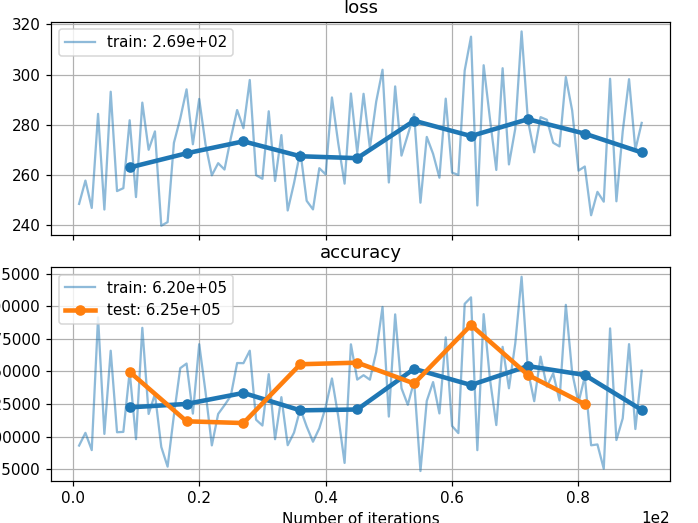

In [77]:
plotter, fig, ax = create_plot(["loss", "accuracy"])

In [96]:
def accuracy(prediction, truth):
    """
    Input
    Prediction a np.ndarray
    Truth a np.ndarray
    _________________________
    
    Output
    ret an integer
    _________________________
    
    """
    
    if isinstance(prediction,mg.Tensor):
        prediction= prediction.data
    if isinstance(truth,mg.Tensor):
        truth= truth.data
    ret=0
    
    #if len(prediction.shape)<2:
    #    prediction.reshape((1,prediction.shape))
    #for i in np.arange(prediction.shape[0]):
    #    ret+=i
    #scipy.spatial.distance.cosine(prediction, truth)[source]
    prediction = prediction.reshape(15*100)
    truth = truth.reshape(15*100)
    ret= np.dot(prediction,truth)/np.linalg.norm(prediction)/np.linalg.norm(truth)
    mag = lambda x: np.sqrt(x.dot(x))
    ret2=np.dot(np.linalg.norm(mag(prediction)), np.linalg.norm(mag(truth)))
    return 1-((2*((1-np.abs(ret))+(1-np.abs(ret2)))))/100

In [97]:
x_total=np.zeros((1070,3,50,200))
x_2total=[]
y_2total=[]
y_total=np.zeros((1070,15))
w_total=[]
xy_total = {}
index=0
for entry in os.listdir("DataSets\samples"):
    if os.path.isfile(os.path.join("DataSets\samples", entry)):
        
        V= "DataSets\samples" 
        #print(f"The file length for {entry} is {(misc.imread(os.path.join(V, entry))).shape}")
        if misc.imread(os.path.join("DataSets\samples", entry),mode = 'RGB').shape[-1] ==3:  
            word = entry[:-4]
            zed=misc.imread(os.path.join("DataSets\samples", entry),mode = 'RGB').transpose(2,0,1)
            x_total[index]=zed
            
            w_total.append(word)
            y_total[index]= encoder(list(word))
            xy_total[word]= (x_total[index],y_total[index])
            index+=1
        else:
            print(f"{entry} is invalid")

for entry in os.listdir("DataSets\MicrosoftDataSet"):
    if os.path.isfile(os.path.join("DataSets\MicrosoftDataSet", entry)):
        
        V= "DataSets\MicrosoftDataSet" 
        #print(f"The file length for {entry} is {(misc.imread(os.path.join(V, entry))).shape}")
        if misc.imread(os.path.join("DataSets\MicrosoftDataSet", entry),mode = 'RGB').shape[-1] ==3:  
            word = ((entry[:-4]).lower()).split()[0]
            zed=misc.imread(os.path.join("DataSets\MicrosoftDataSet", entry),mode = 'RGB').transpose(2,0,1)
            x_2total.append(zed)
            
            w_total.append(word)
            
            y_2total.append(encoder(list(word)))
            xy_total[word]= (zed,encoder(list(word)))
            
        else:
            print(f"{entry} is invalid") 
x_2total=np.array(x_2total)
y_2total=np.array(y_2total)
print(f" x is {x_total.shape}")
print(x_2total.shape)
x_total = x_2total
y_total = y_2total
if x_total.shape[0]==y_total.shape[0]:
    print("x and y are compatable")
else:
    print("x and y are not compatable")
#print(f'x_length is {x_total.shape} and y_length is {y_total.shape}, xy_length is {len(xy_total.values)}, words is {len(words)}')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 x is (1070, 3, 50, 200)
(1184, 3, 96, 216)
x and y are compatable


In [98]:
x_total = x_total.astype(int)
y_total = y_total.astype(int)

In [99]:
print(y_total[0])

[ 3  3 25 32 22  6 31 22 36 36 36 36 36 36 36]


In [100]:
x_train = x_total[:900]
y_train = y_total[:900]
x_test = x_total[900:]
y_test = y_total[900:]
print(f" x is {x_train.shape[0]} , y is {y_train.shape[0]}")

 x is 900 , y is 900


In [101]:
# <COGINST>
batch_size = 100
h=0
g = []

# We will train for ~10 epochs; you can change this if you'd like
for epoch_cnt in range(10):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    for batch_cnt in range(len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_train[batch_indices]  # random batch of our training data

        # compute the predictions for this batch by calling on model
        prediction = model(batch)

        # compute the true (a.k.a desired) values for this batch: 
        truth = y_train[batch_indices]

        # compute the loss associated with our predictions(use softmax_cross_entropy)
        #print(f"predictions is {prediction.shape} and truth is {truth.shape}")
        loss = softmax_crossentropy(prediction, truth)

        # back-propagate through your computational graph through your loss
        loss.backward()

        # compute the accuracy between the prediction and the truth 
        acc = accuracy(prediction, truth)
        #print(f"acc is {acc} of type {type(acc)} the shape is {acc.shape}")

        # execute gradient descent by calling step() of optim
        optim.step()
        
        # null your gradients (please!)
        loss.null_gradients()
        
        # set the training loss and accuracy

        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that 
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(x_test)//batch_size):
        idxs = np.arange(len(x_test))
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_test[batch_indices] 
        
        # get your model's prediction on the test-batch
        try:
            prediction = model(batch) #Was batch.transpose((1,2, 0))
        except Exception as e:
            print(batch.shape)
            print(f"Exception: {e} \n model size is {batch.size}")
            pickle.dump(Model, open("Error batch #"+str(h), 'wb'))
            h+=1
            g.append(batch)
        # get the truth values for that test-batch
        truth = y_test[batch_indices]
        # compute the test accuracy
        acc = accuracy(prediction, truth)
        
        
        # DO NOT back-prop or do gradient descent!
        
        # log the test-accuracy in noggin
        plotter.set_test_batch({"accuracy": acc}, batch_size=batch_size)
    
    plotter.set_train_epoch()
    plotter.set_test_epoch()
# </COGINST>

(100, 3, 96, 216)
Exception: Unable to allocate 586. MiB for an array with shape (13720, 5600) and data type float64 
 model size is 6220800


MemoryError: Unable to allocate 586. MiB for an array with shape (13720, 5600) and data type float64

In [ ]:
#print(Model.parameters)
try:
    pickle.dump(Model, open("Weights.txt", 'wb'))
except:
    print("Fail1")
try:
    pickle.dump(Model,open("Weights.npy","wb"))
except:
    print("Fail2")
try:
    pickle.dump(Model.parameters, open("Weights1.txt", 'wb'))
except:
    print("Fail2")
try:
    pickle.dump(Model.parameters,open("Weights1.npy","wb"))
except:
    print("Fail3")
    #np.save("Weights.txt", Model.parameters)

In [ ]:
loaded_model = pickle.load(open("Weights.txt", 'rb'))

In [ ]:
#print(x_total.shape)
#print(y_total[100])
x=x_total[100:101]
print(f"value is {y_total[100:101]}")
x.reshape((1,3,50,200))
print(x.shape)
z = model(x)
print(decoder(z[0]))
print(f"y decoded is {decoder(y_total[100])}")
print(f"word is {w_total[0]}")

In [ ]:
Z = list(xy_total.keys())[0]
x,y =xy_total[Z]
d = np.zeros((1,3,50,200))
d[0]= x
x= d
mx = model(x)
print(f"Example is {Z}")
print(f"y is {y} of type {type(y)}, size {y.shape}")
print(f"Model returns:{mx}")
print(f"Model decoded is {decoder(mx[0])}")

In [92]:
y_2total[0]

array([ 3.,  3., 25., 32., 22.,  6., 31., 22., 36., 36., 36., 36., 36.,
       36., 36.])

x

In [93]:
x_2total[0].shape

(3, 96, 216)

In [94]:
h = np.reshape(x_2total[0],(1,3,96,216))

In [95]:
l = model(h)

In [53]:
print(l)

[[2224.    0.    0.    0.    0.    0. 2802.  512. 3801. 1982.    0.    0.
     0.    0.    0.]]
